# TD de machine Learning : Catégorisation musicale

**Elective** : Machine Learning   
**Professeur** : Théophile Ravillion   
**Date** : Vendredi 23 Avril 2021

## Récuperer les données 

In [1]:
import pandas as pd
import seaborn as sns

url_train = "https://raw.githubusercontent.com/RTheophile/td_ml_ynov/main/data/train.csv"
url_test = "https://raw.githubusercontent.com/RTheophile/td_ml_ynov/main/data/test.csv"

df_train = pd.read_csv(url_train, sep=',', decimal='.' )
df_test = pd.read_csv(url_test, sep=',', decimal='.' )

## Première visualisation des données

In [2]:
df_train.head()

,music_id,chroma_0_mean,chroma_0_std,chroma_10_mean,chroma_10_std,chroma_11_mean,chroma_11_std,chroma_1_mean,chroma_1_std,chroma_2_mean,...,mfcc_9_std,onset_rate,spectral_centroid_mean,spectral_decrease_mean,spectral_flux_mean,spectral_rolloff_mean,spectral_spread_mean,zcr_mean,zcr_std,category
0,0,866.507629,1585.437134,415.300842,710.790771,683.865845,1011.552856,473.484100,744.247925,304.914825,...,0.647313,3.631719,27.621587,-0.186330,1.962404,1525.877193,1579.021838,190.907164,149.482276,1
1,1,832.956909,2140.568115,287.584564,281.795380,405.467224,754.076904,1061.359863,2263.894531,2502.509033,...,0.575588,6.230564,38.780628,-0.013198,2.139456,1740.789474,1941.791036,257.913214,171.257592,3
2,2,331.544586,553.657532,260.467499,327.618225,283.580139,312.385986,204.369690,225.922531,286.470215,...,0.837297,4.264771,86.371120,-0.155013,1.336048,5243.859649,15422.032531,508.122337,296.141124,3
3,3,454.521851,1170.188110,601.021790,1035.021240,721.523865,1861.131836,350.991791,495.942383,432.551971,...,0.702976,4.064860,16.844325,-0.287745,2.207420,988.596491,999.051613,144.638374,142.303996,1
4,4,180.331635,245.818512,388.924744,917.082581,186.856262,192.765305,212.240402,370.108063,170.875610,...,0.487534,4.164816,5.764473,-0.626706,1.263404,21.491228,735.051431,181.818928,106.604597,1


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   music_id                320 non-null    int64  
 1   chroma_0_mean           317 non-null    float64
 2   chroma_0_std            317 non-null    float64
 3   chroma_10_mean          317 non-null    float64
 4   chroma_10_std           317 non-null    float64
 5   chroma_11_mean          318 non-null    float64
 6   chroma_11_std           320 non-null    float64
 7   chroma_1_mean           318 non-null    float64
 8   chroma_1_std            319 non-null    float64
 9   chroma_2_mean           316 non-null    float64
 10  chroma_2_std            317 non-null    float64
 11  chroma_3_mean           318 non-null    float64
 12  chroma_3_std            313 non-null    float64
 13  chroma_4_mean           316 non-null    float64
 14  chroma_4_std            316 non-null    fl

On élimine les outliers

On constate la présence de valeurs nulles, nous les représenterons en suivant
Les valeurs sont toutes des float64 donc exploitables rapidement sans trop de processing

Première intuition : des colonnes semblent être plus orientées "détails" et d'autres "généralisation". Dans l'optique de produire un modèle simple et efficace, nous éliminerons dans un premier temps tous les détails.

In [4]:
#x_cols = ['chroma_centroid_mean','chroma_flux_mean','chroma_max','chroma_min','chroma_spread_mean', 'onset_rate', 'spectral_centroid_mean','spectral_decrease_mean','spectral_flux_mean','spectral_rolloff_mean','spectral_spread_mean','zcr_mean','zcr_std']
#x_train = df_train[x_cols]
#x_test = df_test[x_cols]
#y_train = df_train['category']
#x_train.head()
nonCorrelatedWithOutput = [column for column in df_train if abs(df_train[column].corr(df_train["category"])) < 0.045]

x_train = df_train.drop(nonCorrelatedWithOutput, axis=1)
x_train.drop(['category'], axis=1,inplace=True)
x_test = df_test.drop(nonCorrelatedWithOutput, axis=1)

#x_train = df_train.drop(['music_id','category'], axis=1)
#x_test = df_test.drop(['music_id'], axis=1)
y_train = df_train.category

### Visualisation des NaN

<AxesSubplot:>

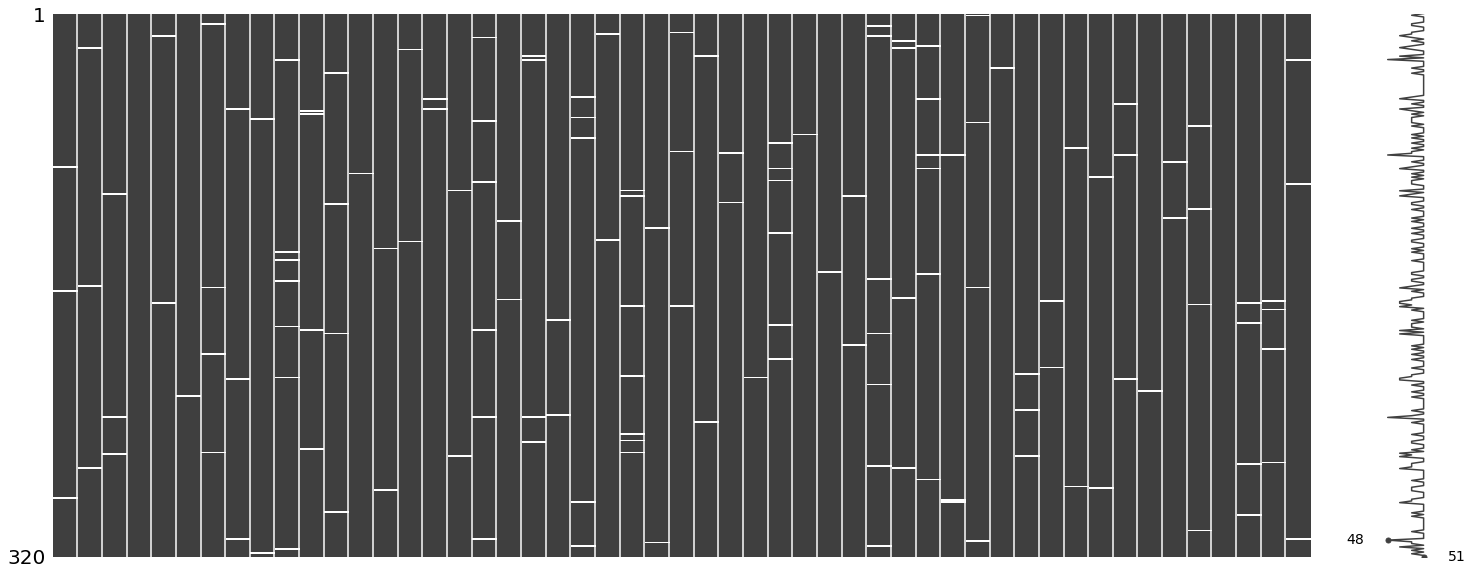

In [5]:
import missingno as msno

msno.matrix(x_train)

On constate des valeurs manquantes éparse, il vaut donc mieux les remplir
Nous utiliserons la valeur moyenne des autres données pour minimiser leur impact

<AxesSubplot:>

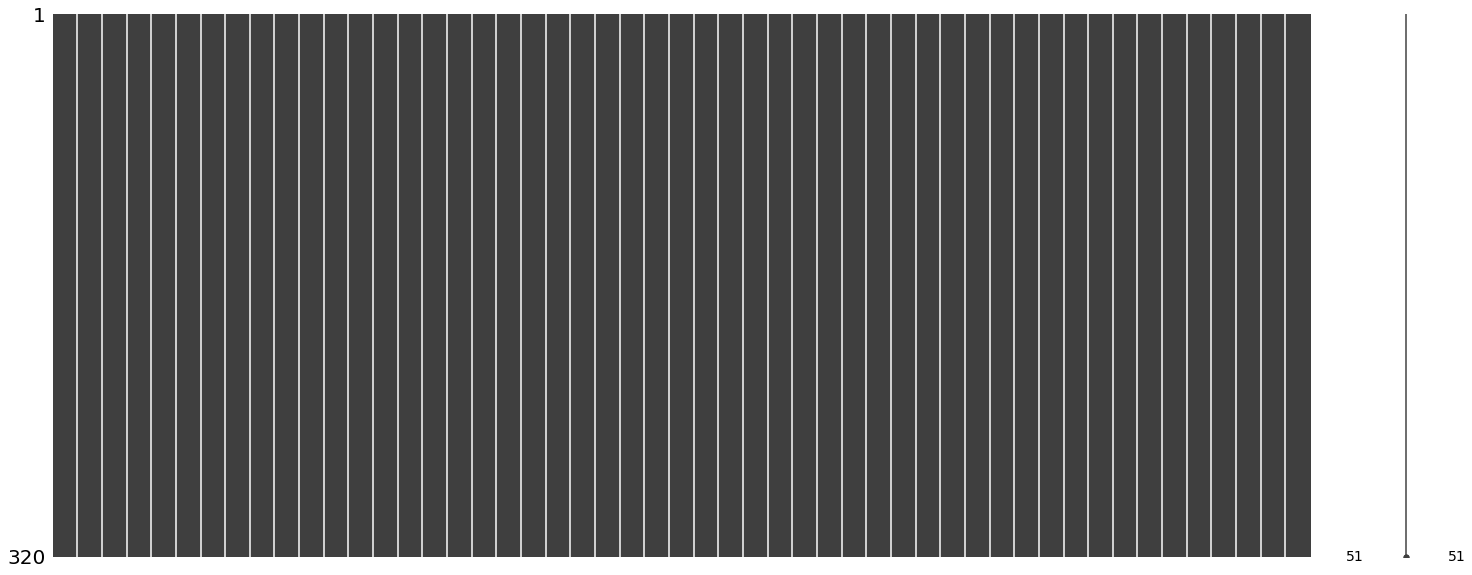

In [6]:
from sklearn.impute import KNNImputer
import numpy as np

#imputer = KNNImputer(n_neighbors=2)
#x_train = imputer.fit_transform(x_train)
#x_test = imputer.fit_transform(x_test)

for col in x_train.columns:
    x_train[col].fillna(x_train[col].mean(), inplace=True)
for col in x_test.columns:
    x_test[col].fillna(x_test[col].mean(), inplace=True)

msno.matrix(x_train)

In [7]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(random_state=0).fit(x_train)
predict_iso = iso.predict(x_train)
print(predict_iso)
for i in range(len(predict_iso)):
    if predict_iso[i] == -1 :
        x_train.drop(i, inplace=True)
        y_train.drop(i, inplace=True)

[ 1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1]


### Visualisation des corrélations

<AxesSubplot:>

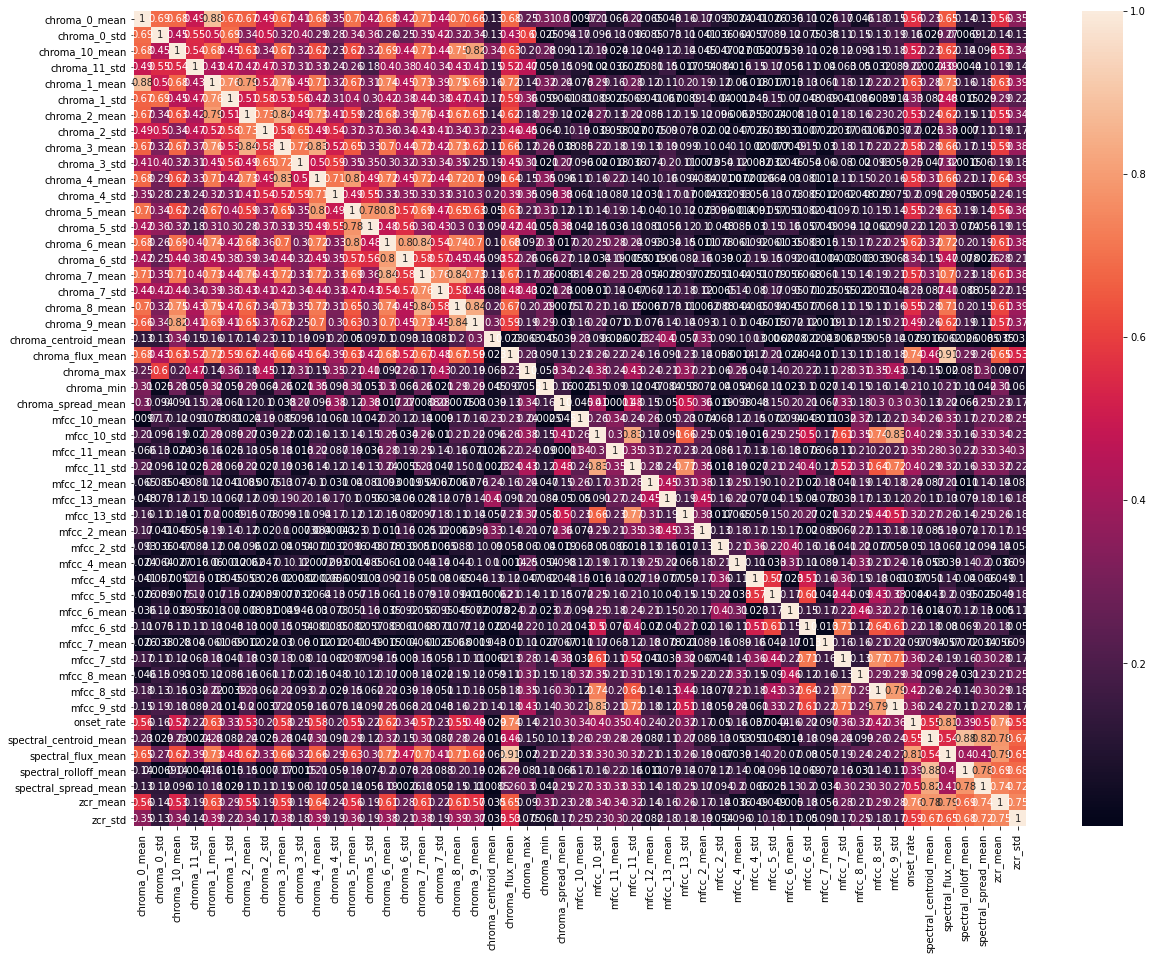

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
corr_matrix = x_train.corr().abs()
sns.heatmap(corr_matrix,annot=True)

Les données restantes ne semblent pas corrélées à outrance, on peut donc les conserver

## Etudier l’opportunité d’une réduction de dimension
- Tester les perfs obtenus pour différentes valeurs
- Visualiser la variance expliquée par chaque axe
- Justifier le nombre d’axes retenus 

[0.89972413 0.06416776 0.0157552  0.00364224 0.00339983]


(0.0, 1.0)

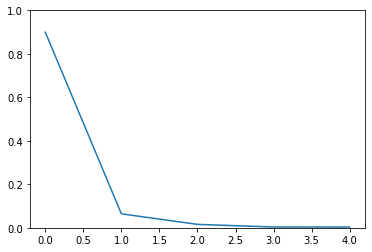

In [9]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=5)
pca_test.fit(x_train)

print(pca_test.explained_variance_ratio_)

plt.plot(pca_test.explained_variance_ratio_)
plt.ylim(0,1)

2 composants nous suffiront donc pour la PCA

In [10]:
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

## Créer un échantillon non biaisé de validation

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train, test_size=0.3)

## Entrainer différents algorithmes de classification

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clf = make_pipeline(MinMaxScaler(), SVC())

L'utilisation de make_pipeline permet une permutation rapide et facile des modèles et scalers pour des tests rapides

In [13]:
clf.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

Y_test_pred = clf.predict(X_test)
Y_train_pred = clf.predict(X_train)
acc_train = accuracy_score(Y_train_pred, Y_train)
acc_score = accuracy_score(Y_test_pred, Y_test)
conf_matrix = confusion_matrix(Y_test_pred, Y_test)
f_score = f1_score(Y_test_pred, Y_test, average='weighted')

print('Accuracy : ', acc_train)
print('-------------------')
print('Accuracy : ', acc_score)
print('Confusion matrix : \n', conf_matrix)
print('f_score : ', f_score)

Accuracy :  0.9238095238095239
-------------------
Accuracy :  0.8681318681318682
Confusion matrix : 
 [[21  0  0  0]
 [ 0 17  3  3]
 [ 0  3 24  0]
 [ 1  1  1 17]]
f_score :  0.8664614455312131


## Optimiser les hyper-paramètres de l’algorithme retenu
Tester différents hyper-paramètres pour tirer au mieux partit de l'algorithme retenu

In [15]:
from sklearn.model_selection import GridSearchCV

RFC_parameters = {'n_estimators':[10,50,100]}
SVC_parameters = {'kernel':('poly', 'rbf'), 'C':[1, 5, 10]}
grid_RFC = RandomForestClassifier()
grid_SVC = SVC()
grid_clf = GridSearchCV(grid_SVC, SVC_parameters)
grid_clf.fit(X_train, Y_train)

Y_test_grid_pred = grid_clf.predict(X_test)

grid_acc_score = accuracy_score(Y_test_grid_pred, Y_test)

print('Accuracy : ', grid_acc_score)

Accuracy :  0.5934065934065934


## Prédire des valeurs pour le jeu de test 

In [27]:
idx = range(0,80)
idx

range(0, 80)

In [30]:
final_model = make_pipeline(MinMaxScaler(), SVC())
final_model.fit(x_train, y_train)

y_test_pred_final = final_model.predict(x_test)
result_df = pd.DataFrame({'music_id':idx,'category':y_test_pred_final})

### Export CSV

In [32]:
result_df.to_csv('test_preds.csv' , sep=',', decimal='.')